# p/b ROE 选股策略

In [1]:
# packages and globals
import pandas as pd
import matplotlib.pyplot as plt
# inline mat
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
# plt.rcParams['figure.dpi'] = 300
import tushare as ts
ts.set_token('4167d168dd2c182108319b0f5fc93d66b21d5ccf2baa2af2a522b80d')
pro = ts.pro_api()

# quiet 执行不显示warning
import warnings
warnings.filterwarnings('ignore')

start_date = '2016-01-01'
end_date = '2023-01-01'

## CSI300

1703


<Axes: xlabel='trade_date'>

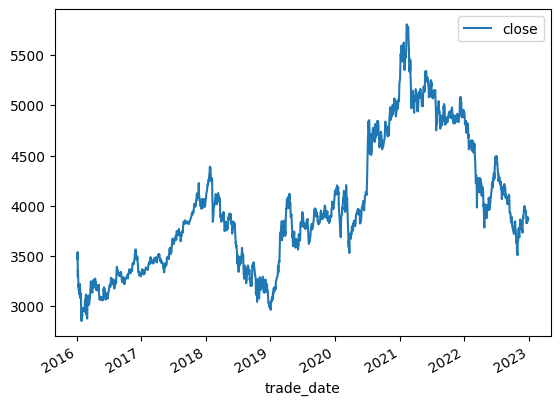

In [2]:
# 沪深300指数
csi300_df = pro.index_daily(ts_code='000300.SH',
                            start_date=start_date,
                            end_date=end_date)
# date to datetime
csi300_df['trade_date'] = pd.to_datetime(csi300_df['trade_date'])
# sort csi300
csi300_df = csi300_df.sort_values(by='trade_date', ascending=True)
print(len(csi300_df))
csi300_df.plot(x='trade_date', y='close')

## Constituent Stocks

dates: 1703
stocks: 50
Index(['000001.SZ', '000069.SZ', '000157.SZ', '000725.SZ', '000768.SZ',
       '000776.SZ', '000858.SZ', '000963.SZ', '002007.SZ', '002008.SZ',
       '002241.SZ', '002304.SZ', '002594.SZ', '002736.SZ', '600015.SH',
       '600016.SH', '600028.SH', '600031.SH', '600036.SH', '600085.SH',
       '600104.SH', '600111.SH', '600519.SH', '600585.SH', '600660.SH',
       '600741.SH', '600837.SH', '600886.SH', '601006.SH', '601186.SH',
       '601211.SH', '601225.SH', '601288.SH', '601318.SH', '601328.SH',
       '601336.SH', '601398.SH', '601601.SH', '601618.SH', '601628.SH',
       '601668.SH', '601688.SH', '601788.SH', '601800.SH', '601857.SH',
       '601888.SH', '601939.SH', '601985.SH', '601988.SH', '601998.SH'],
      dtype='object', name='ts_code')


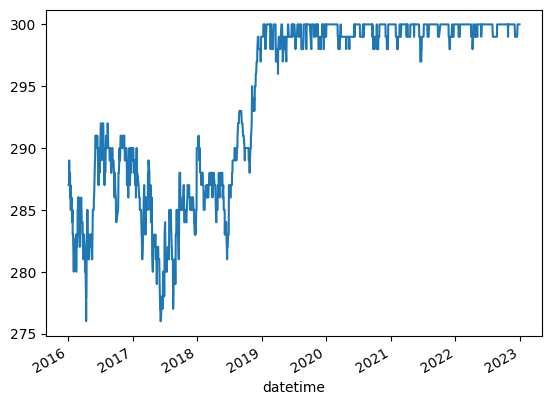

In [3]:
import pandas as pd
import tushare as ts
import matplotlib.pyplot as plt

# read
stocks300_df = pd.read_csv('kaggle/data.csv')
stocks300_df['datetime'] = pd.to_datetime(stocks300_df['datetime'])
# sort
stocks300_df = stocks300_df.sort_values(by=['ts_code', 'datetime'])
# 选取2016之后的
stocks300_df = stocks300_df[stocks300_df['datetime'] > start_date]
# 统计每个date有多少不同股票
stocks300_df.groupby('datetime').ts_code.nunique().plot()
# 日期数量
num_dates = stocks300_df.datetime.nunique()
print('dates:', num_dates)
# 股票数量等于日期数量的股票
stocks = stocks300_df.groupby('ts_code').datetime.nunique()
# 保留等于num_dates的
stocks = stocks[stocks == num_dates].index
print('stocks:', len(stocks))
print(stocks)
# name datetime to trade_date
stocks300_df = stocks300_df.rename(columns={'datetime': 'trade_date'})
# 保留stocks中的股票
stocks300_df = stocks300_df[stocks300_df['ts_code'].isin(stocks)]


## PB

In [4]:
pb_df = pd.DataFrame()
for tic in stocks:
    pb_df = pb_df.append(
        pro.daily_basic(ts_code=tic,
                        start_date=start_date,
                        end_date=end_date,
                        fields='ts_code,trade_date,turnover_rate,pb'))
pb_df['trade_date'] = pd.to_datetime(pb_df['trade_date'])
pb_df = pb_df.sort_values(by=['ts_code', 'trade_date'])
# pb_df = pb_df.set_index('trade_date')
print(len(pb_df))
pb_df.tail(10)

85150


,ts_code,trade_date,turnover_rate,pb
9,601998.SH,2022-12-19,0.0699,0.4516
8,601998.SH,2022-12-20,0.1040,0.4443
7,601998.SH,2022-12-21,0.0529,0.4471
6,601998.SH,2022-12-22,0.0436,0.4471
5,601998.SH,2022-12-23,0.0365,0.4425
4,601998.SH,2022-12-26,0.0557,0.4380
3,601998.SH,2022-12-27,0.0500,0.4443
2,601998.SH,2022-12-28,0.0615,0.4516
1,601998.SH,2022-12-29,0.0765,0.4471
0,601998.SH,2022-12-30,0.0635,0.4516


In [5]:
print(pb_df.trade_date.nunique())
print(pb_df.ts_code.nunique())
pb_df.tail(10)

1703
50


,ts_code,trade_date,turnover_rate,pb
9,601998.SH,2022-12-19,0.0699,0.4516
8,601998.SH,2022-12-20,0.1040,0.4443
7,601998.SH,2022-12-21,0.0529,0.4471
6,601998.SH,2022-12-22,0.0436,0.4471
5,601998.SH,2022-12-23,0.0365,0.4425
4,601998.SH,2022-12-26,0.0557,0.4380
3,601998.SH,2022-12-27,0.0500,0.4443
2,601998.SH,2022-12-28,0.0615,0.4516
1,601998.SH,2022-12-29,0.0765,0.4471
0,601998.SH,2022-12-30,0.0635,0.4516


In [136]:
# reset index
pb_df = pb_df.reset_index(drop=True)
# merge
print(stocks300_df.shape)
print(pb_df.shape)
merge1 = stocks300_df.merge(pb_df, on=['ts_code', 'trade_date'], how='inner')
# check nan
merge1.isna().sum()

trade_date       0
ts_code          0
open             0
high             0
low              0
close            0
pre_close        0
change           0
pct_chg          0
vol              0
amount           0
turnover_rate    0
pb               0
dtype: int64

## ROE

In [6]:
roe_df = pd.DataFrame()
for tic in stocks:
    roe_df = roe_df.append(
        pro.query('fina_indicator', ts_code=tic, 
                  start_date=start_date, 
                  end_date=end_date, 
                  fields='ts_code,end_date,roe'))
roe_df['end_date'] = pd.to_datetime(roe_df['end_date'])
roe_df = roe_df.sort_values(by=['ts_code', 'end_date'])
# roe_df = roe_df.set_index('end_date')
print(len(roe_df))
roe_df.tail(10)

1756


,ts_code,end_date,roe
10,601998.SH,2021-06-30,5.0697
7,601998.SH,2021-09-30,7.2097
8,601998.SH,2021-09-30,7.2097
5,601998.SH,2021-12-31,9.5042
6,601998.SH,2021-12-31,9.5042
4,601998.SH,2022-03-31,2.7393
3,601998.SH,2022-06-30,5.1327
1,601998.SH,2022-09-30,7.3369
2,601998.SH,2022-09-30,7.3369
0,601998.SH,2022-12-31,9.6155


## scatter pb roe

In [7]:
merge3 = roe_df.merge(pb_df, left_on=['ts_code', 'end_date'], right_on=['ts_code', 'trade_date'], how='inner').drop('end_date', axis=1)

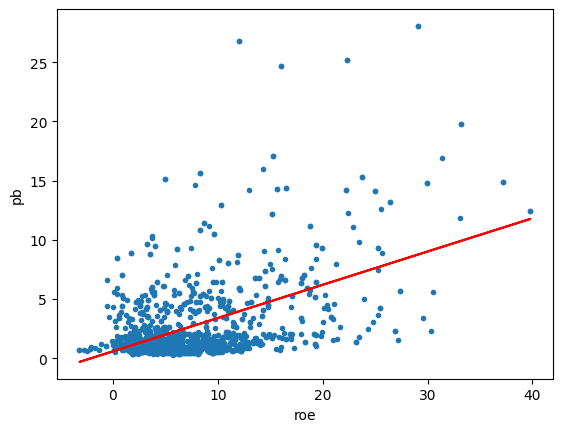

In [8]:
# linear regression
from sklearn.linear_model import LinearRegression

# create linear regression object
reg = LinearRegression()
# fit
reg.fit(merge3[['roe']], merge3['pb'])

# plot
plt.scatter(merge3['roe'], merge3['pb'],marker='.')
plt.plot(merge3['roe'], reg.predict(merge3[['roe']]), color='red')
plt.xlabel('roe')
plt.ylabel('pb')
plt.show()


In [9]:
# 根据回归选择pb被低估的股票
merge3['pb_pred'] = reg.predict(merge3[['roe']])

# 统计股票pb被低估的次数
merge3['pb_pred'] = merge3['pb'] < merge3['pb_pred'] * 0.8
undervalue_freq = merge3.groupby('ts_code').pb_pred.sum().sort_values(ascending=False)

# add name freq
undervalue_freq = undervalue_freq.to_frame().reset_index()
undervalue_freq.columns = ['ts_code', 'freq']
undervalue_freq.sample(3)

,ts_code,freq
35,000725.SZ,7
31,601688.SH,13
25,600585.SH,17


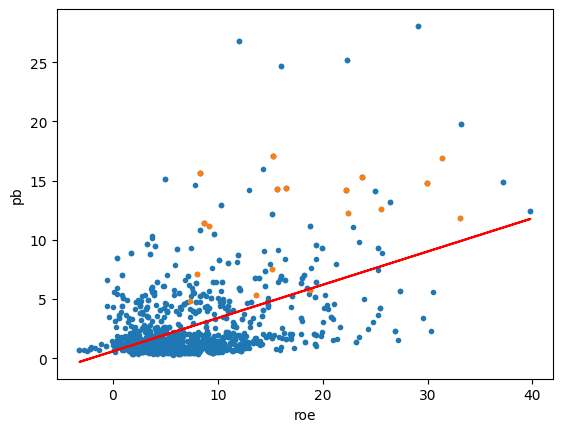

In [15]:
# scatter pb roe 其中 601800.SH 颜色不同
test_stock = '600519.SH'
plt.scatter(merge3['roe'], merge3['pb'],marker='.')
plt.scatter(merge3[merge3['ts_code'] == test_stock]['roe'], merge3[merge3['ts_code'] == test_stock]['pb'],marker='.')
plt.plot(merge3['roe'], reg.predict(merge3[['roe']]), color='red')
plt.xlabel('roe')
plt.ylabel('pb')
plt.show()

In [14]:
# 600519.SH
undervalue_freq[undervalue_freq['ts_code'] == '600519.SH']

,ts_code,freq
46,600519.SH,0


In [180]:
# 生成trade_date 序列 1703
trade_dates = pd.DataFrame(merge1.trade_date.unique(), columns=['trade_date'])
# merge trade_dates and roe
merge2 = trade_dates.merge(roe_df, left_on='trade_date', right_on='end_date', how='left').drop('end_date', axis=1)
# 最近值填充
# merge2 = merge2.fillna(method='ffill')
merge2[50:100]

,trade_date,ts_code,roe
50,2016-03-21,NaN,NaN
51,2016-03-22,NaN,NaN
52,2016-03-23,NaN,NaN
53,2016-03-24,NaN,NaN
54,2016-03-25,NaN,NaN
55,2016-03-28,NaN,NaN
56,2016-03-29,NaN,NaN
57,2016-03-30,NaN,NaN
58,2016-03-31,000001.SZ,3.4870
59,2016-03-31,000069.SZ,1.5720


In [158]:
merge1.merge(roe_df,
             left_on=['ts_code', 'trade_date'],
             right_on=['ts_code', 'end_date'],
             how='left').sample(20)

,trade_date,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,turnover_rate,pb,end_date,roe
9193,2018-08-21,000776.SZ,13.39,13.54,13.30,13.36,13.39,-0.03,-0.2240,192478.92,258538.917,0.3252,1.2259,NaT,NaN
68038,2021-07-27,601628.SH,29.36,29.55,28.27,28.50,29.45,-0.95,-3.2258,166525.82,480575.093,0.0800,1.7915,NaT,NaN
46611,2017-10-31,600886.SH,7.54,7.57,7.48,7.50,7.58,-0.08,-1.0600,174483.73,131100.836,0.2571,1.6824,NaT,NaN
18727,2022-09-08,002241.SZ,32.96,33.20,32.41,32.42,32.96,-0.54,-1.6383,493468.54,1619814.748,1.6424,3.7583,NaT,NaN
73173,2021-08-13,601788.SH,15.43,15.50,15.20,15.28,15.42,-0.14,-0.9079,331913.62,508489.553,0.8496,1.4020,NaT,NaN
72440,2018-08-10,601788.SH,10.78,10.86,10.73,10.81,10.78,0.03,0.2783,37352.72,40313.335,0.0956,1.0266,NaT,NaN
9778,2021-01-18,000776.SZ,16.85,17.53,16.81,17.18,16.82,0.36,2.1403,1304196.77,2247480.923,2.2033,1.3617,NaT,NaN
63513,2017-01-18,601601.SH,28.78,29.13,28.76,29.02,28.88,0.14,0.4800,39709.93,115220.365,0.0632,2.0071,NaT,NaN
19649,2019-06-25,002304.SZ,121.89,122.67,118.81,121.15,121.61,-0.46,-0.3783,51124.44,615180.614,0.4095,4.8267,NaT,NaN
26434,2019-03-28,600016.SH,6.22,6.23,6.16,6.20,6.25,-0.05,-0.8000,985597.55,609607.778,0.2779,0.6616,NaT,NaN
